### Objetivo

Neste exercício, vamos estender o que é pedido no exercício 1 da seção 11.7 de GH (página 248). Vamos analisar dados de infestação de roedores em Nova Iorque, e modelar a probabilidade de um apartamento estar infestado, levando em conta o distrito ("neighbourhood") e outras características específicas do imóvel em questão (como a etnia dos seus ocupantes).

In [3]:
library(tidyverse)
library(GGally)  # ggpairs
library(MuMIn)  # AICc (Akaike Information Criterion corrected for small sample size)
library(MASS)  # negative.binomial
library(readr)
library(ggplot2)
library(gridExtra)
library(rstanarm)
library(pROC)
library(boot)
library(foreign)
library(arm)
library(lattice)
library(lme4)
library(parallel)

urlfile = "https://raw.githubusercontent.com/maxbiostat/stats_modelling/master/data/mickey_mouse.csv"
data <- read_csv(url(urlfile))

Rows: 4209 Columns: 57
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (57): bldg, y, defects, poor, race.x, floor, dist, borough, numunits, st...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
head(data)

bldg,y,defects,poor,race.x,floor,dist,borough,numunits,stories,⋯,struct_Mean,dilap_Mean,ownhous_Mean,duration_Mean,extwin4_2_Mean,extflr5_2_Mean,intcrack2_Mean,inthole2_Mean,intleak2_Mean,vacrate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
33,1,5.000000,5,3,5,1,1,10,4,⋯,0.43,0.03,0.05,11.6,0.02,0.07,0.22,0.16,0.27,0.05
35,1,5.000000,4,3,6,1,1,10,4,⋯,0.43,0.03,0.05,11.6,0.02,0.07,0.22,0.16,0.27,0.05
35,1,5.000000,4,3,6,1,1,10,4,⋯,0.43,0.03,0.05,11.6,0.02,0.07,0.22,0.16,0.27,0.05
35,1,3.000000,6,2,5,1,1,10,4,⋯,0.43,0.03,0.05,11.6,0.02,0.07,0.22,0.16,0.27,0.05
35,1,3.000000,6,2,5,1,1,10,4,⋯,0.43,0.03,0.05,11.6,0.02,0.07,0.22,0.16,0.27,0.05
39,1,1.163636,5,4,6,1,1,8,4,⋯,0.43,0.03,0.05,11.6,0.02,0.07,0.22,0.16,0.27,0.05


In [5]:
data$race.x <- factor(data$race.x, labels=c("White (non-hispanic)", "Black (non-hispanic)", "Puerto Rican", "Other Hispanic", "Asian/Pacific Islander", "Amer-Indian/Native Alaskan", "Two or more races"))
data$borough <- factor(data$borough, labels=c("Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"))
data$housing <- factor(data$housing, labels=c("public", "rent controlled/stabilized", "owned", "other rentals"))

summary(data)

      bldg            y             defects            poor      
 Min.   :  33   Min.   :0.0000   Min.   :0.0000   Min.   :1.000  
 1st Qu.:2286   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:2.000  
 Median :4789   Median :0.0000   Median :0.0000   Median :3.000  
 Mean   :4612   Mean   :0.2287   Mean   :0.9973   Mean   :3.061  
 3rd Qu.:6872   3rd Qu.:0.0000   3rd Qu.:1.1412   3rd Qu.:4.000  
 Max.   :9033   Max.   :1.0000   Max.   :9.0000   Max.   :8.000  
                NA's   :527                                      
                        race.x         floor            dist     
 White (non-hispanic)      :1961   Min.   :1.000   Min.   : 1.0  
 Black (non-hispanic)      : 938   1st Qu.:2.000   1st Qu.:16.0  
 Puerto Rican              : 404   Median :4.000   Median :32.0  
 Other Hispanic            : 572   Mean   :4.187   Mean   :29.6  
 Asian/Pacific Islander    : 283   3rd Qu.:6.000   3rd Qu.:42.0  
 Amer-Indian/Native Alaskan:  18   Max.   :9.000   Max.   :55.0  
 Two or mo

In [6]:
data$hispanic_Mean10 <- data$hispanic_Mean * 10
data$black_Mean10 <- data$black_Mean * 10

test_m1 <- glm(rodent2 ~ race.x + hispanic_Mean10 + black_Mean10, data=data, family=binomial(link="logit"))
display(test_m1)

glm(formula = rodent2 ~ race.x + hispanic_Mean10 + black_Mean10, 
    family = binomial(link = "logit"), data = data)
                                 coef.est coef.se
(Intercept)                      -2.68     0.10  
race.xBlack (non-hispanic)        0.75     0.14  
race.xPuerto Rican                0.72     0.15  
race.xOther Hispanic              1.02     0.14  
race.xAsian/Pacific Islander     -0.04     0.21  
race.xAmer-Indian/Native Alaskan  0.75     0.51  
race.xTwo or more races           0.40     0.50  
hispanic_Mean10                   0.25     0.02  
black_Mean10                      0.12     0.02  
---
  n = 3682, k = 9
  residual deviance = 3490.7, null deviance = 3959.4 (difference = 468.7)


In [7]:
# fit model
test_m2 <- glm(rodent2 ~ race.x + hispanic_Mean10 + black_Mean10 + borough + old + housing + personrm + struct + foreign, data=data, family=binomial(link="logit"))
display(test_m2)

glm(formula = rodent2 ~ race.x + hispanic_Mean10 + black_Mean10 + 
    borough + old + housing + personrm + struct + foreign, family = binomial(link = "logit"), 
    data = data)
                                  coef.est coef.se
(Intercept)                       -2.32     0.29  
race.xBlack (non-hispanic)         0.55     0.15  
race.xPuerto Rican                 0.54     0.17  
race.xOther Hispanic               0.66     0.15  
race.xAsian/Pacific Islander      -0.20     0.22  
race.xAmer-Indian/Native Alaskan   0.38     0.57  
race.xTwo or more races            0.47     0.52  
hispanic_Mean10                    0.15     0.03  
black_Mean10                       0.06     0.02  
boroughBrooklyn                    0.24     0.15  
boroughManhattan                   0.04     0.14  
boroughQueens                     -0.34     0.16  
boroughStaten Island              -0.56     0.35  
old                                0.11     0.10  
housingrent controlled/stabilized  0.71     0.20  
housi

In [8]:
quebrado <- split(data, data$dist)

ajuda_modelo <- function(data){
    glm(rodent2~ poverty, data=data, family="binomial")
}

#fits <- lapply(quebrado, ajuda_modelo)
fits <- mclapply(quebrado, ajuda_modelo)

Warning message:
"glm.fit: algoritmo não convergiu"


In [9]:
coeficientes <- lapply(quebrado, ajuda_modelo)

Warning message:
"glm.fit: algoritmo não convergiu"


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00557577 (tol = 0.002, component 1)"


$dist


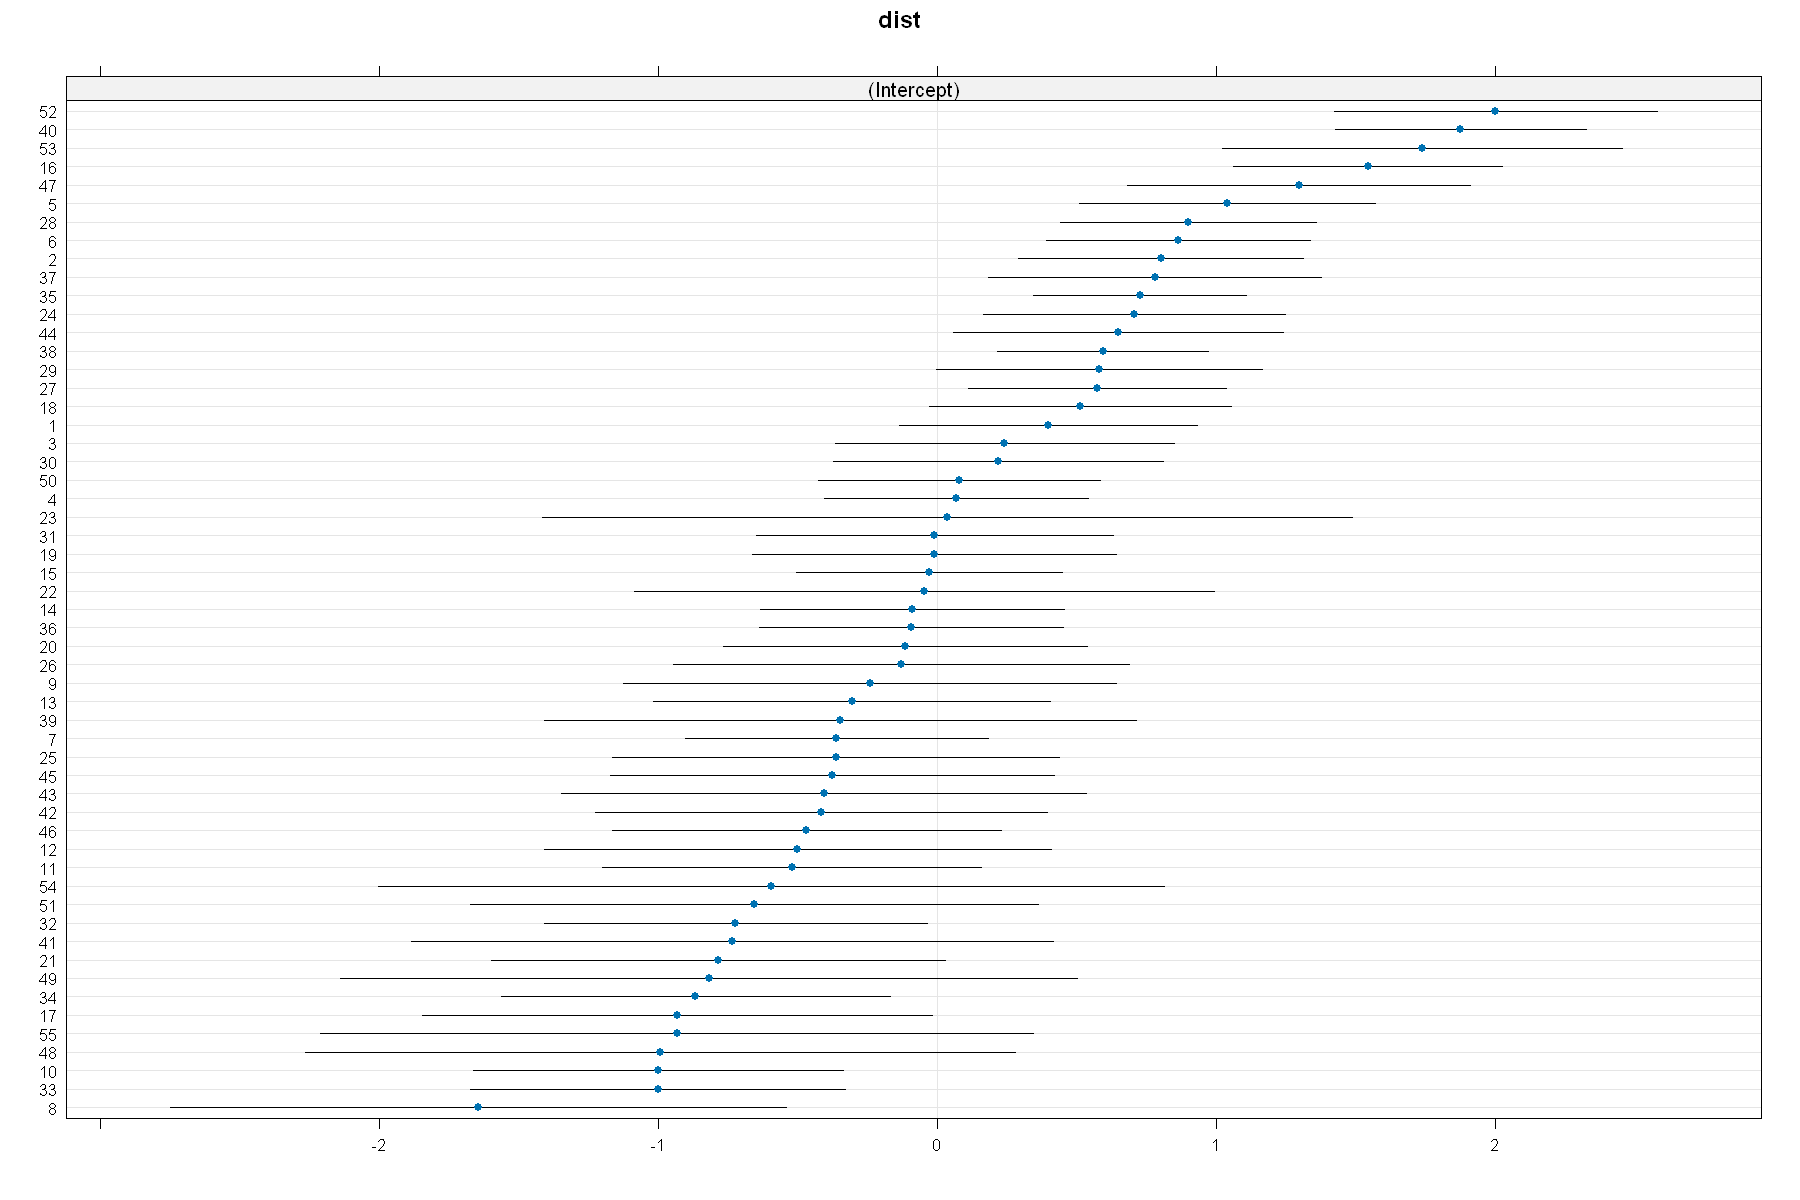

In [11]:
options(repr.plot.width = 15, repr.plot.height = 10)
M1 <- glmer(rodent2 ~ race.x + borough + old + housing + poverty + struct + foreign + (1|dist), data=data, family=binomial(link="logit"))
dotplot(ranef(M1))